In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
'''
This is the source code for bayesian LSTM for electricity load prediction.
@copyright: Copyright 2020 Mr. Kevin Hu. (https://github.com/KevinHooah)
@licence: Apache License 2.0 (http://www.apache.org/licenses/)
@author: Kevin Hu
'''

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
import numpy as np
import matplotlib.pyplot as plt
SMALL_SIZE = 25
MEDIUM_SIZE = 28
BIGGER_SIZE = 44
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE)  
%matplotlib inline
import seaborn as sns
import math
from math import sqrt
from tqdm import tqdm
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(tensorflow.__version__)

2.8.2


In [ ]:
dpath = "/content/drive/MyDrive/2022_물빅데이터공모전/데이터/"
df = pd.read_csv(dpath + 'data_jh_final.csv')
df['wqdt'][9] = '2019-01-10'
df['wqdt'][11] = '2019-01-12'
df['wqdt'][187] = '2019-07-07'
df["wqdt"] = pd.to_datetime(df["wqdt"])
df

,wqdt,bCod,bTn
0,2019-01-01,14.4,10.370
1,2019-01-02,14.0,10.181
2,2019-01-03,12.2,9.746
3,2019-01-04,12.6,8.880
4,2019-01-05,15.0,9.691
...,...,...,...
1030,2021-10-27,7.5,6.286
1031,2021-10-28,7.6,5.268
1032,2021-10-29,6.7,5.438
1033,2021-10-30,6.9,5.834


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wqdt    1035 non-null   datetime64[ns]
 1   bCod    1035 non-null   float64       
 2   bTn     1035 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 24.4 KB


# bCod

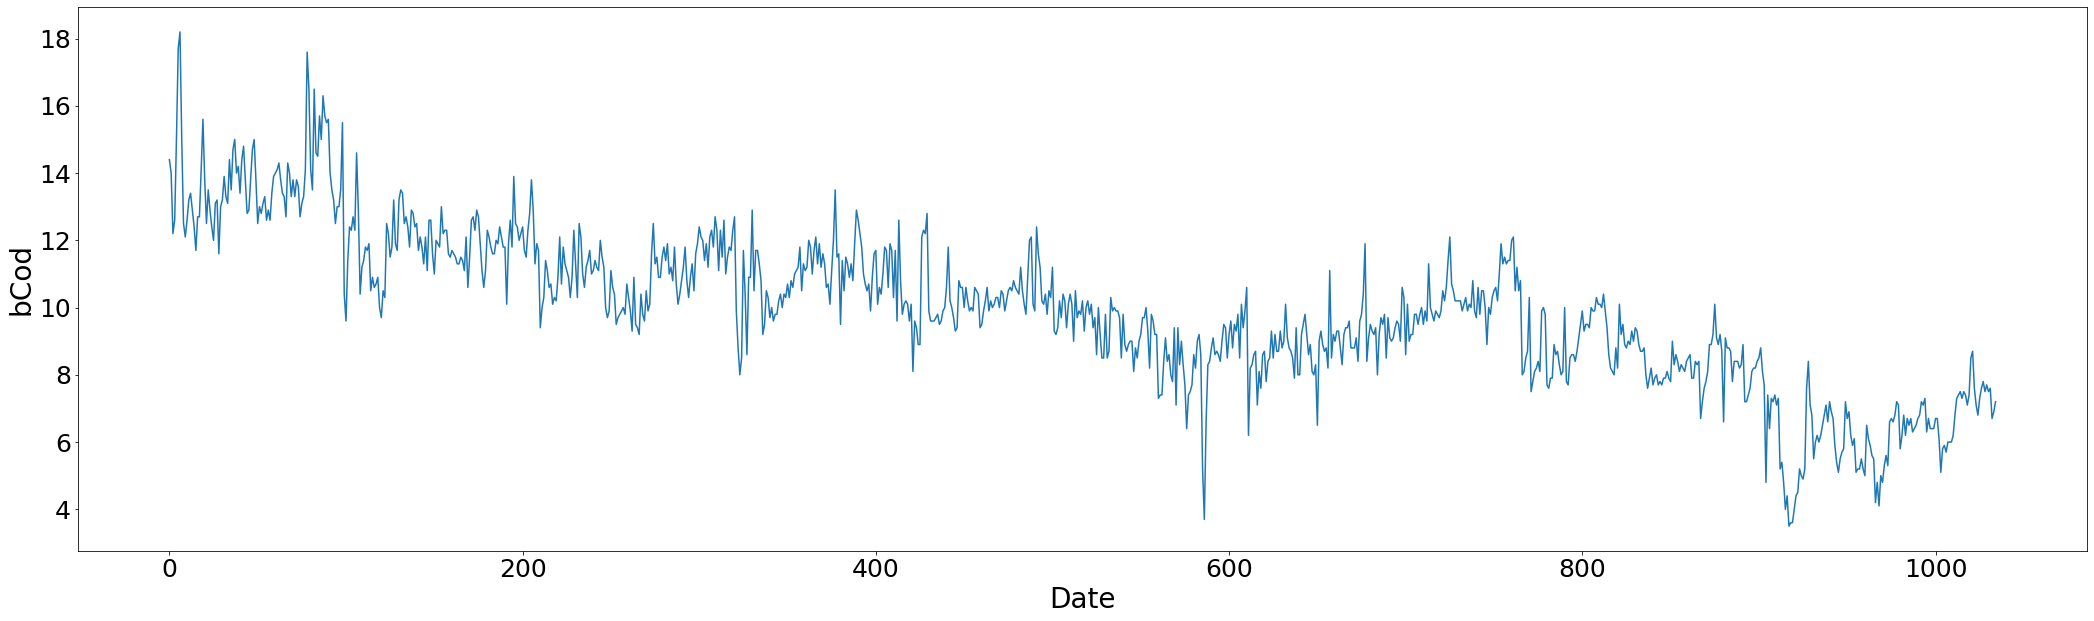

In [ ]:
plt.figure(figsize=(36,10))
plt.plot(df.bCod)
plt.xlabel('Date')
plt.ylabel('bCod')
plt.show()

In [ ]:
dataset = df.bCod.values
#dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [ ]:
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [ ]:
#Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

776 259


In [ ]:
def creat_dataset(data, lagTerm=1):
    # To create the dataset for later use.
    # lagTerm: How many previous timestemp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm -1):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 6
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [ ]:
#reshape input into to be [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Set a valida set to avoid overfitting
validX = trainX[776:]
validY = trainY[776:]
trainX = trainX[:775]
trainY = trainY[:775]

## Model

In [ ]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(256, input_shape=(1,look_back),dropout=0.1, recurrent_dropout = 0.1)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

In [ ]:
# Early stop callback function.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

In [ ]:
theModel, ELBO = fitModel(100,1,trainX,trainY,validX,validY,[early_stopping_cb])

Epoch 1/100
25/25 - 4s - loss: 0.2355 - 4s/epoch - 147ms/step
Epoch 2/100
25/25 - 0s - loss: 0.1050 - 233ms/epoch - 9ms/step
Epoch 3/100
25/25 - 0s - loss: 0.1007 - 240ms/epoch - 10ms/step
Epoch 4/100
25/25 - 0s - loss: 0.0987 - 224ms/epoch - 9ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0944 - 235ms/epoch - 9ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0925 - 237ms/epoch - 9ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0874 - 243ms/epoch - 10ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0932 - 242ms/epoch - 10ms/step
Epoch 9/100
25/25 - 0s - loss: 0.0910 - 231ms/epoch - 9ms/step
Epoch 10/100
25/25 - 0s - loss: 0.0916 - 232ms/epoch - 9ms/step
Epoch 11/100
25/25 - 0s - loss: 0.0927 - 259ms/epoch - 10ms/step
Epoch 12/100
25/25 - 0s - loss: 0.0927 - 229ms/epoch - 9ms/step
Epoch 13/100
25/25 - 0s - loss: 0.0880 - 233ms/epoch - 9ms/step
Epoch 14/100
25/25 - 0s - loss: 0.0933 - 231ms/epoch - 9ms/step
Epoch 15/100
25/25 - 0s - loss: 0.0871 - 236ms/epoch - 9ms/step
Epoch 16/100
25/25 - 0s - loss: 0.0992 - 239ms

In [ ]:
eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


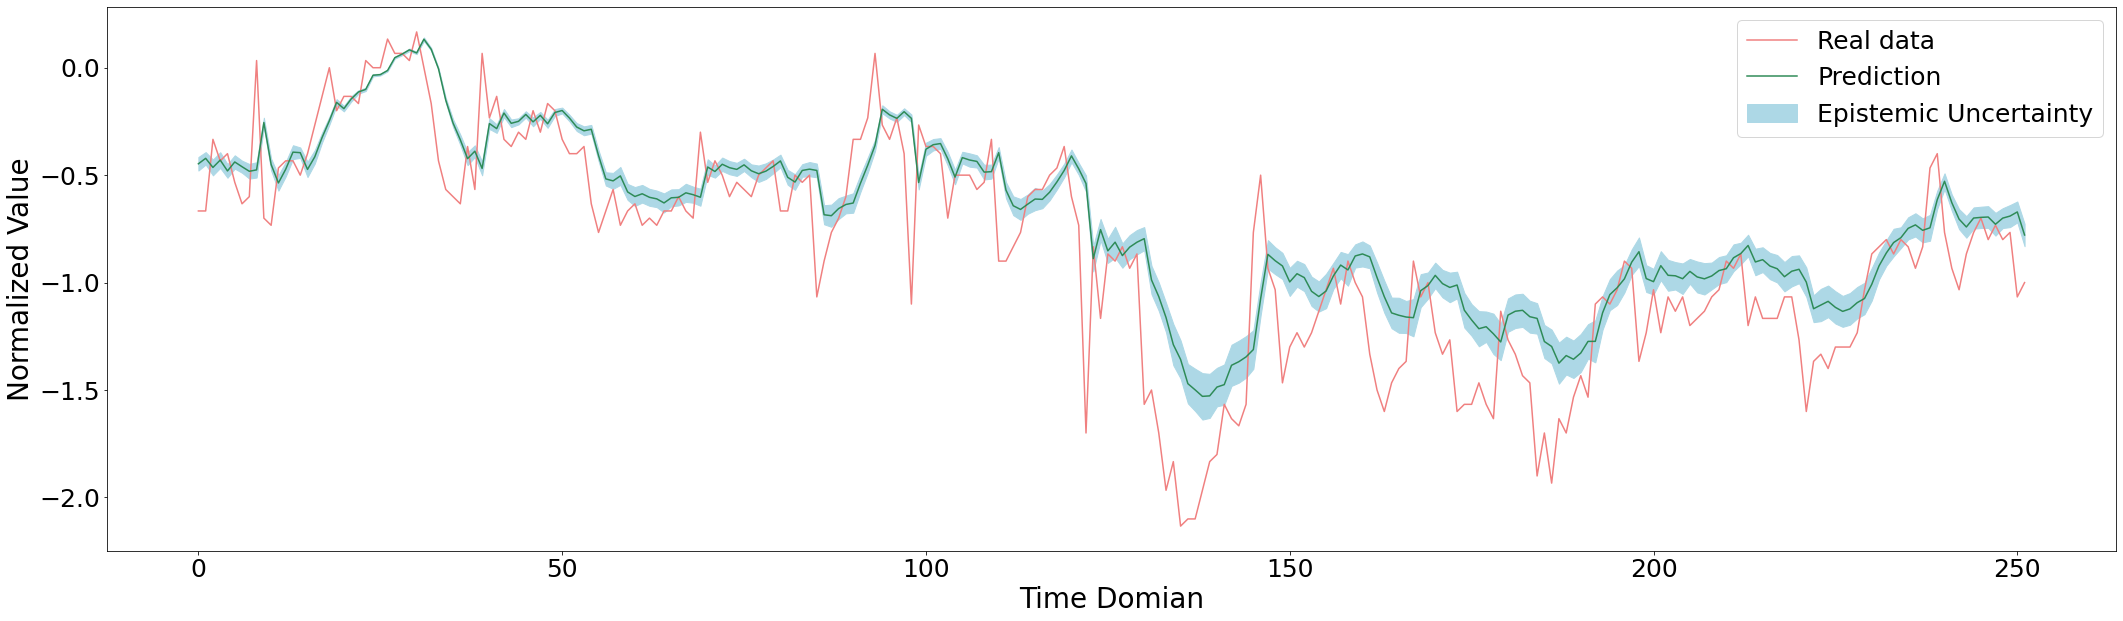

In [ ]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*v**0.5, m + 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

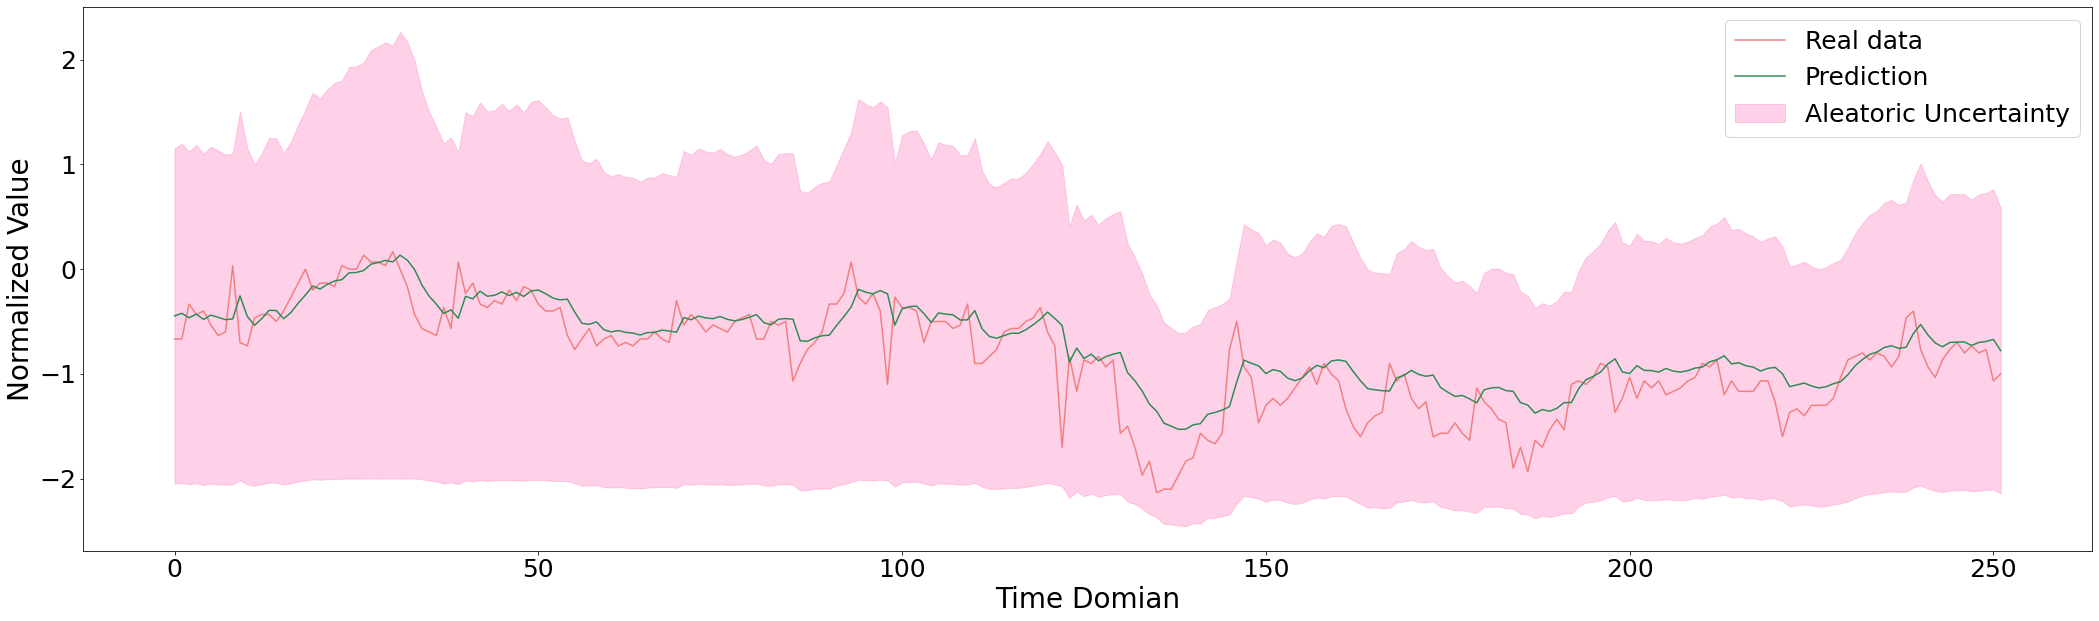

In [ ]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*a_u**0.5, m + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

In [ ]:
# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Test RMSE: 0.82 
Test MSE: 0.66 
Test r_squared: 0.70.


# bTn

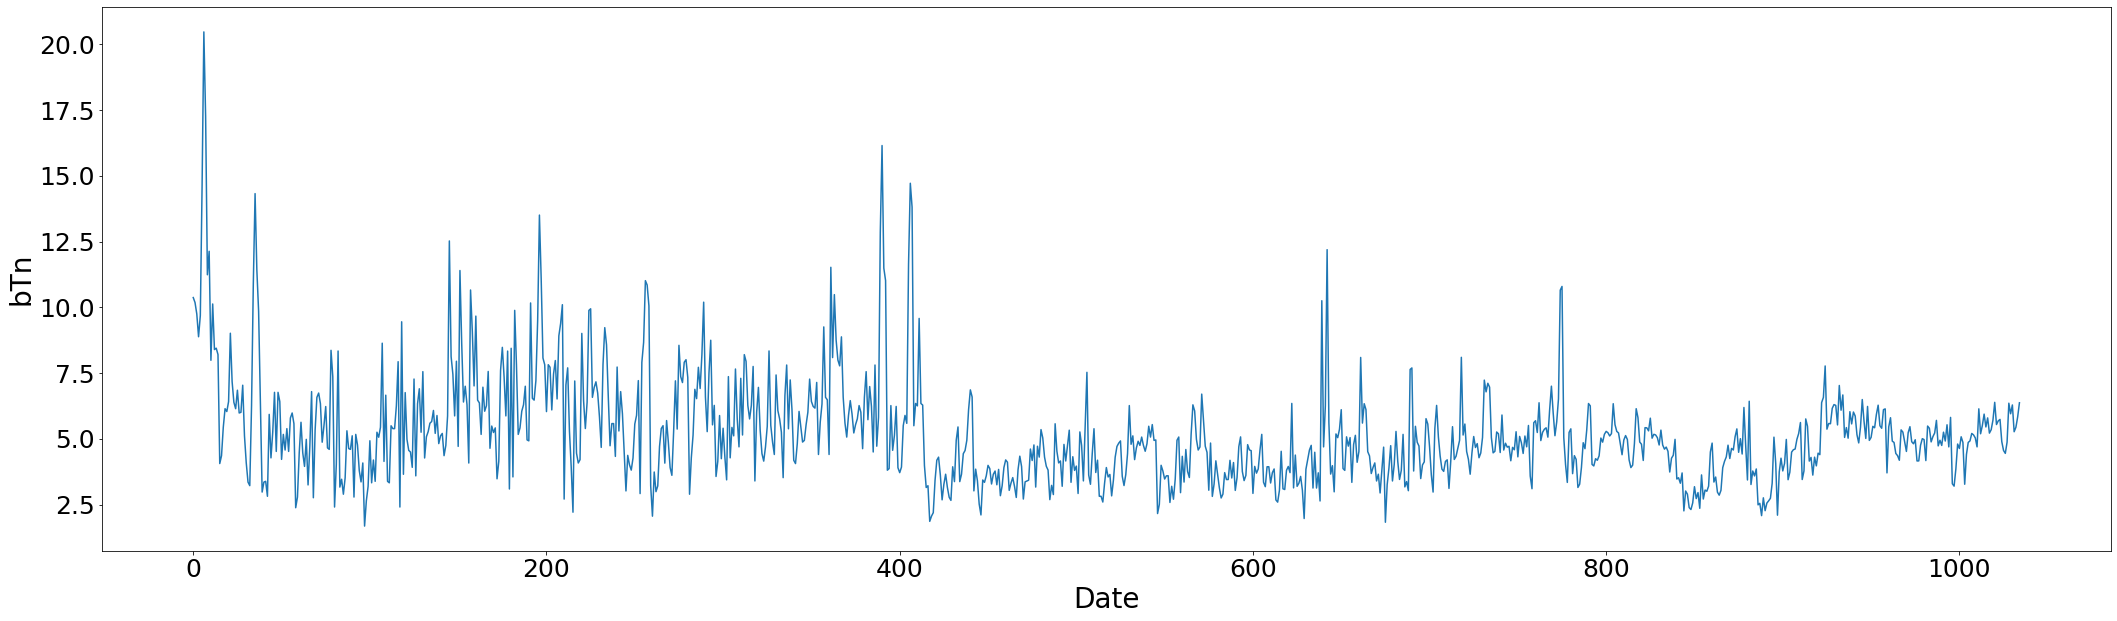

In [ ]:
plt.figure(figsize=(36,10))
plt.plot(df.bTn)
plt.xlabel('Date')
plt.ylabel('bTn')
plt.show()

In [ ]:
dataset = df.bTn.values
#dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [ ]:
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [ ]:
#Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

776 259


In [ ]:
def creat_dataset(data, lagTerm=1):
    # To create the dataset for later use.
    # lagTerm: How many previous timestemp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm -1):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 6
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [ ]:
#reshape input into to be [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Set a valida set to avoid overfitting
validX = trainX[776:]
validY = trainY[776:]
trainX = trainX[:775]
trainY = trainY[:775]

## Model

In [ ]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(256, input_shape=(1,look_back),dropout=0.1, recurrent_dropout = 0.1)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

In [ ]:
# Early stop callback function.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

In [ ]:
theModel, ELBO = fitModel(100,1,trainX,trainY,validX,validY,[early_stopping_cb])

Epoch 1/100
25/25 - 5s - loss: 0.9484 - 5s/epoch - 186ms/step
Epoch 2/100
25/25 - 0s - loss: 0.7798 - 377ms/epoch - 15ms/step
Epoch 3/100
25/25 - 0s - loss: 0.7620 - 413ms/epoch - 17ms/step
Epoch 4/100
25/25 - 0s - loss: 0.7457 - 330ms/epoch - 13ms/step
Epoch 5/100
25/25 - 0s - loss: 0.7398 - 356ms/epoch - 14ms/step
Epoch 6/100
25/25 - 0s - loss: 0.7257 - 382ms/epoch - 15ms/step
Epoch 7/100
25/25 - 0s - loss: 0.7125 - 326ms/epoch - 13ms/step
Epoch 8/100
25/25 - 0s - loss: 0.6905 - 356ms/epoch - 14ms/step
Epoch 9/100
25/25 - 0s - loss: 0.7107 - 347ms/epoch - 14ms/step
Epoch 10/100
25/25 - 0s - loss: 0.6800 - 364ms/epoch - 15ms/step
Epoch 11/100
25/25 - 0s - loss: 0.6628 - 372ms/epoch - 15ms/step
Epoch 12/100
25/25 - 0s - loss: 0.6669 - 410ms/epoch - 16ms/step
Epoch 13/100
25/25 - 1s - loss: 0.6906 - 503ms/epoch - 20ms/step
Epoch 14/100
25/25 - 0s - loss: 0.6965 - 456ms/epoch - 18ms/step
Epoch 15/100
25/25 - 0s - loss: 0.6638 - 230ms/epoch - 9ms/step
Epoch 16/100
25/25 - 0s - loss: 0.661

In [ ]:
eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

100%|██████████| 100/100 [00:06<00:00, 14.98it/s]


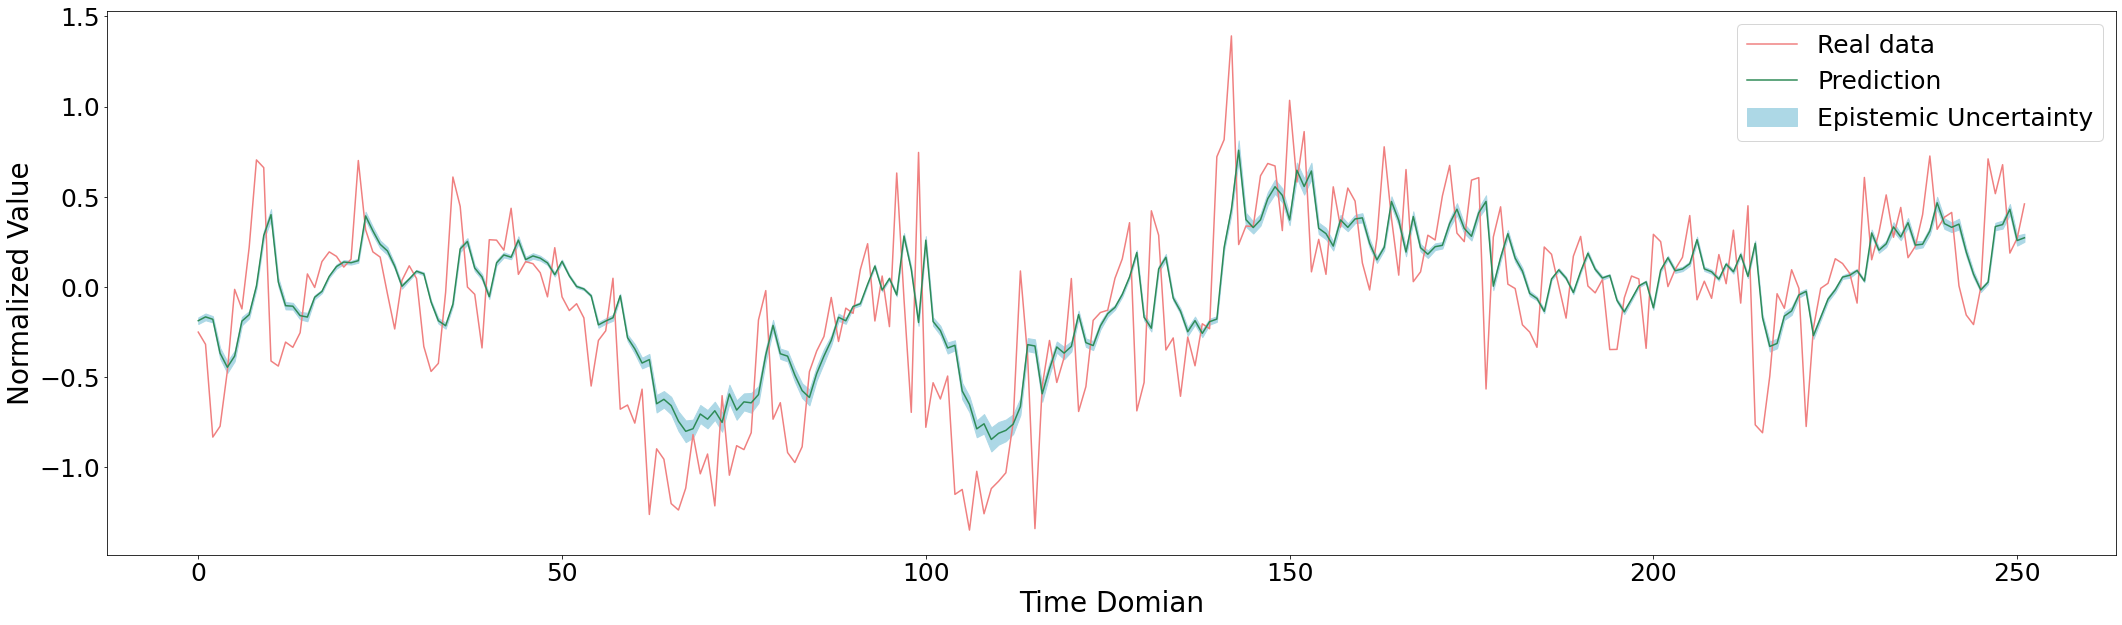

In [ ]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*v**0.5, m + 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

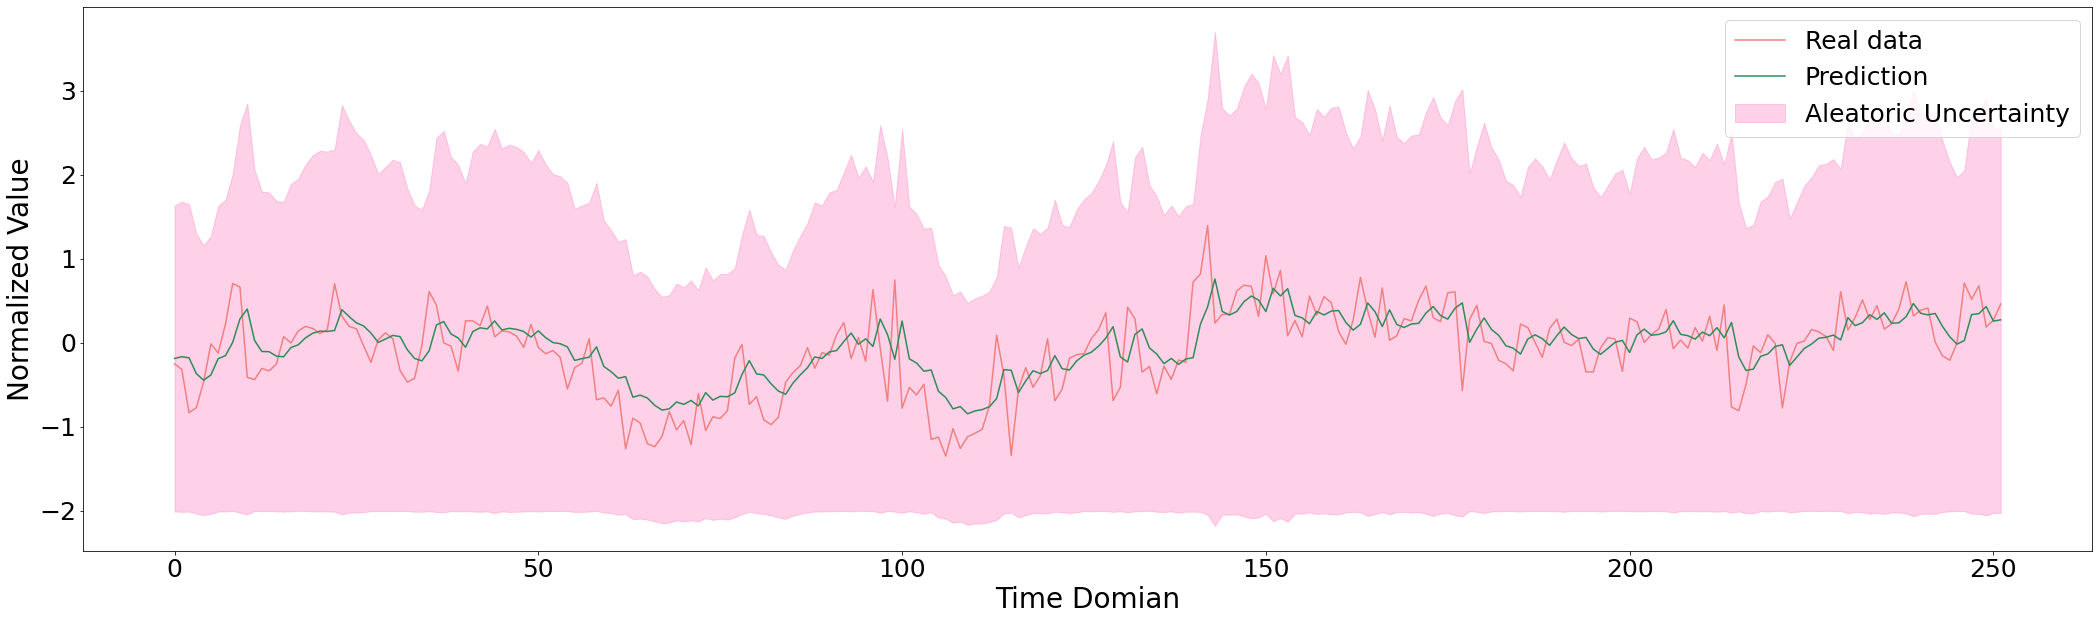

In [ ]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*a_u**0.5, m + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

In [ ]:
# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Test RMSE: 0.73 
Test MSE: 0.54 
Test r_squared: 0.52.
